In [26]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True,
                                              transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False,
                                             transform = transforms.Compose([transforms.ToTensor()]))

In [29]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

In [30]:
#데이터셋에 대한 라벨링
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [31]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

In [32]:
print(len(train_set), len(test_set))

60000 10000


9


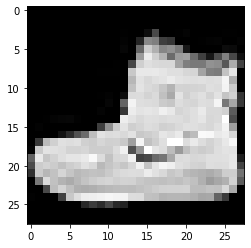

In [33]:
# matplotlib.pyplot 데이터셋 시각화
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap='gray')
print(label)

In [52]:
# CNN 모델 구성
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
    
                

In [53]:
# 모델 구조 파악하기
model = CNN()
model.to(device)

error = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [57]:
# training
num_epochs = 15
count = 0

# 실앵에 필요한 loss, iteration. accuracy 시각화를 위해 list형태로 토기화
loss_list=[]
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                
                total += len(labels)
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}")

iteration: 500, Loss: 2.291923761367798, Accuracy: 7.559999942779541
iteration: 1000, Loss: 2.346101760864258, Accuracy: 7.349999904632568
iteration: 1500, Loss: 2.3187601566314697, Accuracy: 7.549999713897705
iteration: 2000, Loss: 2.331026554107666, Accuracy: 7.460000038146973
iteration: 2500, Loss: 2.3333559036254883, Accuracy: 7.659999847412109
iteration: 3000, Loss: 2.3197550773620605, Accuracy: 7.409999847412109
iteration: 3500, Loss: 2.3105013370513916, Accuracy: 7.46999979019165
iteration: 4000, Loss: 2.345313310623169, Accuracy: 7.579999923706055
iteration: 4500, Loss: 2.339221954345703, Accuracy: 7.689999580383301
iteration: 5000, Loss: 2.372570276260376, Accuracy: 7.87999963760376
iteration: 5500, Loss: 2.3039584159851074, Accuracy: 7.309999942779541
iteration: 6000, Loss: 2.337347984313965, Accuracy: 7.739999771118164
iteration: 6500, Loss: 2.3128931522369385, Accuracy: 7.169999599456787
iteration: 7000, Loss: 2.355454444885254, Accuracy: 7.599999904632568
iteration: 7500, 

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

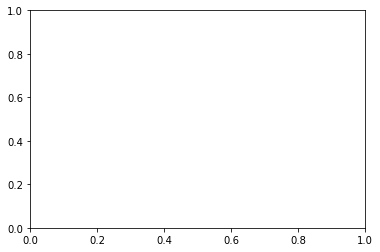

In [63]:
# 시각화
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [61]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
            
for i in range(10):
    print(f"Accuracy of {output_label(i)}: {class_correct[i]*100/total_correct[i]:.2f}%")

Accuracy of T-shirt/Top: 0.40%
Accuracy of Trouser: 5.70%
Accuracy of Pullover: 1.00%
Accuracy of Dress: 0.00%
Accuracy of Coat: 2.00%
Accuracy of Sandal: 3.80%
Accuracy of Shirt: 43.00%
Accuracy of Sneaker: 1.30%
Accuracy of Bag: 12.00%
Accuracy of Ankle Boot: 2.60%
